# Purpose:
- Check qc results of 736963 (Thyme)

In [16]:
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
from brain_observatory_qc.data_access import from_lims
from matplotlib import pyplot as plt
import seaborn as sns

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache as bpc

from pymongo import MongoClient
mongo = MongoClient("flaskapp.corp.alleninstitute.org", 27017)


In [2]:
def get_mongo_client(username, password, host, port):
    client = MongoClient(f'mongodb://{username}:{password}@{host}:{port}')
    return client


def get_zdrift(opid):
    try:
        client = get_mongo_client('public', 'public_password', 'qc-sys-db', 27017)
    except:
        raise('Failed to connect to mongo')
    
    opid = int(opid)
    try:
        record = client.records.metrics.find_one({'data_id': opid})
    except:
        raise('No record found for opid: ', opid)
        
    try:
        zdrift = record['local_z_stack']['z_drift_corr_um_diff']
    except:
        zdrift = np.nan
    return zdrift

In [61]:
cache = bpc.from_lims()
table = cache.get_ophys_experiment_table(passed_only=False)
print(len(table))
table = table.reset_index()
table = table.drop_duplicates(subset='ophys_experiment_id')
table = table.set_index('ophys_experiment_id', drop=True)
print(len(table))

17213
15826


In [75]:
thyme_table = table.query('mouse_id == "736963"')[['mouse_id', 'imaging_depth', 'date_of_acquisition', 
                'ophys_session_id', 'session_type', 'project_code',
                'experiment_workflow_state']].sort_values('date_of_acquisition')
sorted_doa = np.sort(thyme_table.date_of_acquisition.unique())

thyme_table['session_index'] = thyme_table.date_of_acquisition.map({date: i for i, date in enumerate(sorted_doa)})
thyme_table['depth_order'] = thyme_table.groupby('session_index').imaging_depth.rank()

thyme_table['zdrift'] = thyme_table.index.map(get_zdrift)
thyme_table['abs_zdrift'] = thyme_table['zdrift'].abs()

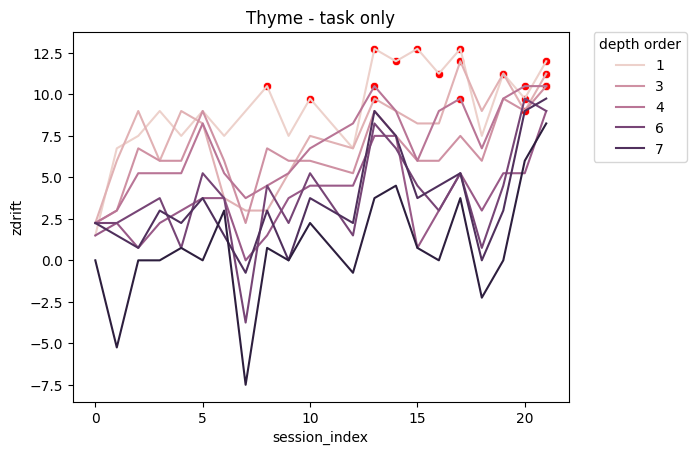

In [84]:
fig, ax = plt.subplots()
thyme_table['depth_order'] = thyme_table['depth_order'].astype(int)
sns.lineplot(data=thyme_table, x='session_index', y='zdrift', hue='depth_order', ax=ax)
ax.set_title('Thyme - task only')
# set legend outside of the axis
sns.scatterplot(data=thyme_table.query('experiment_workflow_state=="failed"'),
                x='session_index', y='zdrift', ax=ax, color='r')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="depth order")


In [86]:
len(thyme_table.query('experiment_workflow_state=="failed"')) / len(thyme_table)

0.11363636363636363

In [88]:
len(thyme_table.query('abs_zdrift>=10')) / len(thyme_table)

0.08522727272727272

# Check QC failure rate across recent Slc32a1;Oi1 mice
- Compare with GAD2;Ai195

In [98]:
recent_table = table.query('date_of_acquisition >= "2024-01-01"').copy()
slc32a1_oi1 = recent_table.query('full_genotype == "Slc32a1-IRES-Cre/wt;Oi1(TIT2L-jGCaMP8s-WPRE-ICL-IRES-tTA2)/wt"').copy()
gad2_ai195 = recent_table.query('full_genotype == "Gad2-IRES-Cre/wt;Slc32a1-T2A-FlpO/wt;Ai195(TIT2L-GC7s-ICF-IRES-tTA2)-hyg/wt"').copy()
print(len(slc32a1_oi1), len(gad2_ai195))

1884 1056


In [94]:
len(slc32a1_oi1.query('experiment_workflow_state=="failed"')) / len(slc32a1_oi1)

0.21709129511677283

In [95]:
len(gad2_ai195.query('experiment_workflow_state=="failed"')) / len(gad2_ai195)

0.3475378787878788

In [99]:

slc32a1_oi1['depth_order'] = slc32a1_oi1.groupby('ophys_session_id').imaging_depth.rank()
slc32a1_oi1['zdrift'] = slc32a1_oi1.index.map(get_zdrift)
slc32a1_oi1['abs_zdrift'] = slc32a1_oi1['zdrift'].abs()

gad2_ai195['depth_order'] = gad2_ai195.groupby('ophys_session_id').imaging_depth.rank()
gad2_ai195['zdrift'] = gad2_ai195.index.map(get_zdrift)
gad2_ai195['abs_zdrift'] = gad2_ai195['zdrift'].abs()

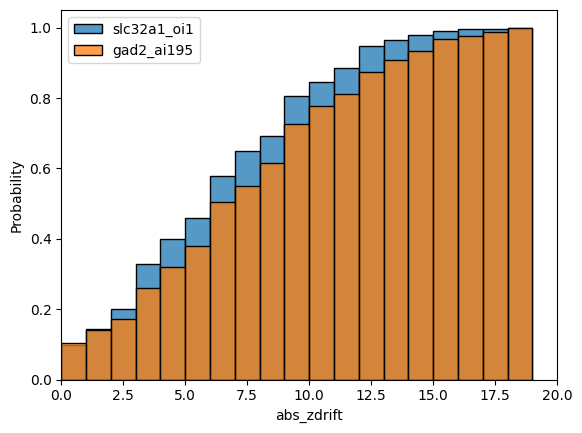

In [110]:
fig, ax = plt.subplots()
sns.histplot(slc32a1_oi1['abs_zdrift'], ax=ax, label='slc32a1_oi1', kde=False,
    bins=np.arange(0, 20, 1), stat='probability', cumulative=True)
sns.histplot(gad2_ai195['abs_zdrift'], ax=ax, label='gad2_ai195', kde=False,
    bins=np.arange(0, 20, 1), stat='probability', cumulative=True)
ax.set_xlim(0, 20)
ax.legend()

In [112]:
len(slc32a1_oi1.query('abs_zdrift >= 10')) / len(slc32a1_oi1)

0.1921443736730361

In [113]:
len(gad2_ai195.query('abs_zdrift >= 10')) / len(gad2_ai195)

0.2803030303030303

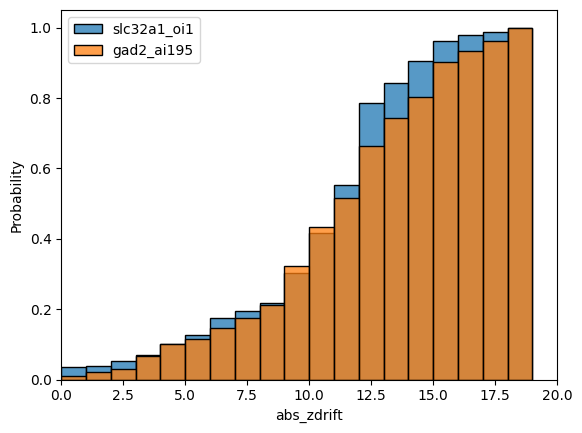

In [115]:
fig, ax = plt.subplots()
sns.histplot(slc32a1_oi1.query('experiment_workflow_state=="failed"')['abs_zdrift'], ax=ax, label='slc32a1_oi1', kde=False,
    bins=np.arange(0, 20, 1), stat='probability', cumulative=True)
sns.histplot(gad2_ai195.query('experiment_workflow_state=="failed"')['abs_zdrift'], ax=ax, label='gad2_ai195', kde=False,
    bins=np.arange(0, 20, 1), stat='probability', cumulative=True)
ax.set_xlim(0, 20)
ax.legend()